In [1]:
from time import sleep
import Pyro5.api 
import matplotlib.pyplot as plt
from TimeTagger import *
import numpy as np
from scipy.optimize import curve_fit

In [2]:
file = 'C:/Users/HP/Downloads/TimeTags_PW_Ful_2025-02-06_153714.ttbin' #QD_29 (PW)

In [3]:
fr = FileReader(file)
print("All channels available: {}".format(fr.getChannelList()))

print("Has data? ->", fr.hasData())
# Returns: True if more data is available for reading, False if all data has been read from all the files specified in the class constructor.

All channels available: (1, 2)
Has data? -> True


In [4]:
# Now we are going to print all the configuration of the TT-Ultra at the moment of the measurement
config = fr.getConfiguration()

for key, value in config.items():
    print(f"{key}: {value}")

channel number scheme: 2
configure version: 1
current time: 2025-02-06 15:37:14 +0100
devices: [{'FPGA ID': 11493476189726804, 'PCB UID': '00fdf287', 'PCB version': '1.8 (1)', 'minimum software version': '2.10.6', 'model': 'Time Tagger Ultra', 'serial': '2410001ABQ'}]
firmware version: TT-Ultra, FW6, TS 2024-02-09 12:21:10, OK 1.46
fpga link: {'enabled': False}
hardware buffer size: 67108864
inputs: [{'average rising falling': [False, False], 'channel': [1, -1], 'conditional filter filtered': [False, False], 'conditional filter triggers': [False, False], 'deadtime': [2000, 2000], 'delay hardware': [0, 0], 'delay software': [0, 0], 'event divider': [1, 1], 'hardware delay compensation': [333, 333], 'high priority channel': [False, False], 'input hysteresis': 0, 'input impedance high': False, 'input mux': 0, 'normalization': [True, True], 'resolution': 'Standard', 'resolution rms': 42.0, 'trigger level': 0.5}, {'average rising falling': [False, False], 'channel': [2, -2], 'conditional fi

In [5]:
virtual_tagger = createTimeTaggerVirtual()
virtual_tagger.getConfiguration()

{'configure version': 1,
 'current time': '2025-02-09 16:17:07 +0100',
 'hardware configuration': None,
 'measurements': [],
 'replay speed': -1.0,
 'software clock': None,
 'software version': '2.17.4',
 'virtual inputs': []}


Correlation measurement is running.



Rate of counts channel 1 (counts/sec) : 4562.786636618219
Total counts channel 1 : 2762146
Rate of counts channel 2 (counts/sec) : 4321.275676717165
Total counts channel 2 : 2615944


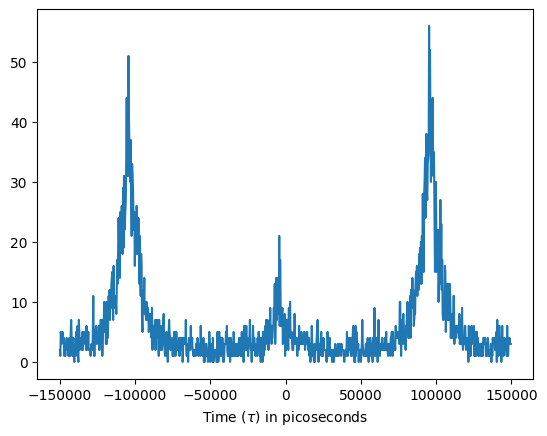

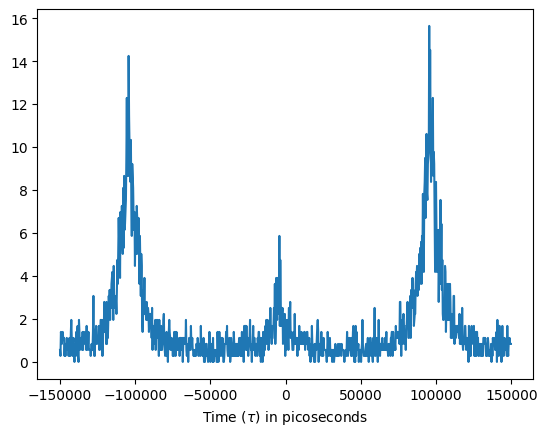

In [6]:
# measure photon antibunching
corr_ch1 = config['registered channels'][0] # first photon channel for antibunching measurements
corr_ch2 = config['registered channels'][1] # second photon channel for antibunching measurements
bwcorr = 300 # 1 ns
nbins = 1000

corr = Correlation(virtual_tagger, corr_ch1, corr_ch2, bwcorr, nbins)
cr = Countrate(virtual_tagger, [corr_ch1, corr_ch2])
print("\nCorrelation measurement is running.\n")


virtual_tagger.setReplaySpeed(-1.0) # Speed of -1.0 will replay the data as fast as possible
virtual_tagger.replay(file, begin = 0, duration = -1) # collect data until the end 
#virtual_tagger.replay(file, duration=8*10e11) # collect only 1 sec. of data (duration in picoseconds)
virtual_tagger.waitForCompletion()

# normalized correlation -> Photon Antibunching
xcorr = corr.getIndex()
ycorr_norm = corr.getDataNormalized()
ycorr = corr.getData()

rate_ch1 = cr.getData()[0]
rate_ch2 = cr.getData()[1]
counts_ch1 = cr.getCountsTotal()[0]
counts_ch2 = cr.getCountsTotal()[1]

print(f"Rate of counts channel {corr_ch1} (counts/sec) : {cr.getData()[0]}")
print(f"Total counts channel {corr_ch1} : {cr.getCountsTotal()[0]}")
print(f"Rate of counts channel {corr_ch2} (counts/sec) : {cr.getData()[1]}")
print(f"Total counts channel {corr_ch2} : {cr.getCountsTotal()[1]}")

plt.plot(xcorr, ycorr)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

plt.plot(xcorr, ycorr_norm)
plt.xlabel(r'Time ($\tau$) in picoseconds')
plt.show()

In [7]:
# Normalize counts 
capture_duration = np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]) * 1e12 # Capture duration in picoseconds
print("Capture duration (seconds): ", np.mean([counts_ch1/rate_ch1, counts_ch2/rate_ch2]))

counts_normalized = (ycorr  * capture_duration)/(bwcorr * counts_ch1 * counts_ch2) 

Capture duration (seconds):  605.363831355307


In [8]:
# Define the fitting function: 
def fitting_function(tau, a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right):
    return a + (b_left * np.exp(-np.abs(tau - t_0_left) / tau_0_left)) + (b * np.exp(-np.abs(tau - t_0) / tau_0)) + (b_right * np.exp(-np.abs(tau - t_0_right) / tau_0_right))


# Function to normalize counts and fit the data
def fit_noblinking(tau, counts):
    # Initial parameter guess [a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right]
    p0 = [1, 1, -100, 5, 1, 0, 5, 1, 100, 5]
    
    # Perform the curve fitting
    popt, pcov = curve_fit(fitting_function, tau, counts, p0=p0)
    
    return popt, pcov

# Function to plot the normalized data and the fitted curve
def plot_fit_noblinking(tau, counts, params, width, height, font_size):
    # Create the plot
    plt.figure(figsize=(width, height))
    
    # Plot normalized data
    plt.plot(tau, counts, linestyle='-', color='black', linewidth=0.7, label='Normalized Data')
    
    # Generate the fitted curve
    tau_fine = np.linspace(min(tau), max(tau), 100000)
    fitted_curve = fitting_function(tau_fine, *params)
    
    # Plot fitted curve
    plt.plot(tau_fine, fitted_curve, 'g-', label='Fitted Curve')
    
    # Etiquetas de los ejes con tamaño de fuente modificado
    plt.xlabel('Time differences (ns)', fontsize=font_size)
    plt.ylabel('Counts', fontsize=font_size)
    
    # Cambiar el tamaño de los números en los ejes
    plt.xticks(fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # plt.legend()
    plt.grid(True)
    plt.show()

## Obtention of non-normalized graph

In [9]:
params, pcov = fit_noblinking(xcorr/1000, ycorr)

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))

print(f"a: {params[0]:.3f} ± {perr[0]:.3f} counts")
print(f"b_left: {params[1]:.3f} ± {perr[1]:.3f} counts")
print(f"t_0_left: {params[2]:.3f} ± {perr[2]:.3f} ns")
print(f"tau_0_left: {params[3]:.3f} ± {perr[3]:.3f} ns \n")

print(f"b: {params[4]:.3f} ± {perr[4]:.3f} counts")
print(f"t_0: {params[5]:.3f} ± {perr[5]:.3f} ns")
print(f"tau_0: {params[6]:.3f} ± {perr[6]:.3f} ns \n")

print(f"b_right: {params[7]:.3f} ± {perr[7]:.3f} counts")
print(f"t_0_right: {params[8]:.3f} ± {perr[8]:.3f} ns")
print(f"tau_0_right: {params[9]:.3f} ± {perr[9]:.3f} ns \n")

a: 2.511 ± 0.110 counts
b_left: 37.234 ± 0.751 counts
t_0_left: -104.359 ± 0.097 ns
tau_0_left: 6.813 ± 0.210 ns 

b: 9.514 ± 0.922 counts
t_0: -4.224 ± 0.311 ns
tau_0: 4.535 ± 0.655 ns 

b_right: 40.773 ± 0.783 counts
t_0_right: 95.895 ± 0.085 ns
tau_0_right: 6.273 ± 0.183 ns 



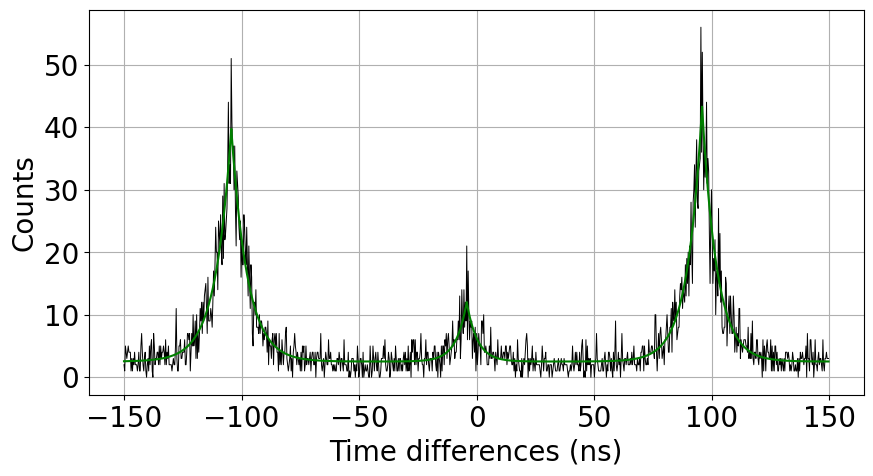

In [10]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr/1000, ycorr, params, width=10, height=5, font_size=20)

## Obtention of the normalized graph

In [19]:
popt, pcov = fit_noblinking(xcorr/1000, counts_normalized)
# Extract fitted parameters
a, b_left, t_0_left, tau_0_left, b, t_0, tau_0, b_right, t_0_right, tau_0_right = popt

counts_normalized = 2 * counts_normalized/ (b_left + b_right)

params, pcov = fit_noblinking(xcorr/1000, counts_normalized)

# Calculate the standard deviations of the parameters
perr = np.sqrt(np.diag(pcov))

print(f"a: {params[0]:.3f} ± {perr[0]:.3f} counts")
print(f"b_left: {params[1]:.3f} ± {perr[1]:.3f} counts")
print(f"t_0_left: {params[2]:.3f} ± {perr[2]:.3f} ns")
print(f"tau_0_left: {params[3]:.3f} ± {perr[3]:.3f} ns \n")

print(f"b: {params[4]:.3f} ± {perr[4]:.3f} counts")
print(f"t_0: {params[5]:.3f} ± {perr[5]:.3f} ns")
print(f"tau_0: {params[6]:.3f} ± {perr[6]:.3f} ns \n")

print(f"b_right: {params[7]:.3f} ± {perr[7]:.3f} counts")
print(f"t_0_right: {params[8]:.3f} ± {perr[8]:.3f} ns")
print(f"tau_0_right: {params[9]:.3f} ± {perr[9]:.3f} ns \n")

a: 0.064 ± 0.003 counts
b_left: 0.955 ± 0.019 counts
t_0_left: -104.359 ± 0.097 ns
tau_0_left: 6.813 ± 0.210 ns 

b: 0.244 ± 0.024 counts
t_0: -4.224 ± 0.311 ns
tau_0: 4.537 ± 0.655 ns 

b_right: 1.045 ± 0.020 counts
t_0_right: 95.895 ± 0.085 ns
tau_0_right: 6.273 ± 0.183 ns 



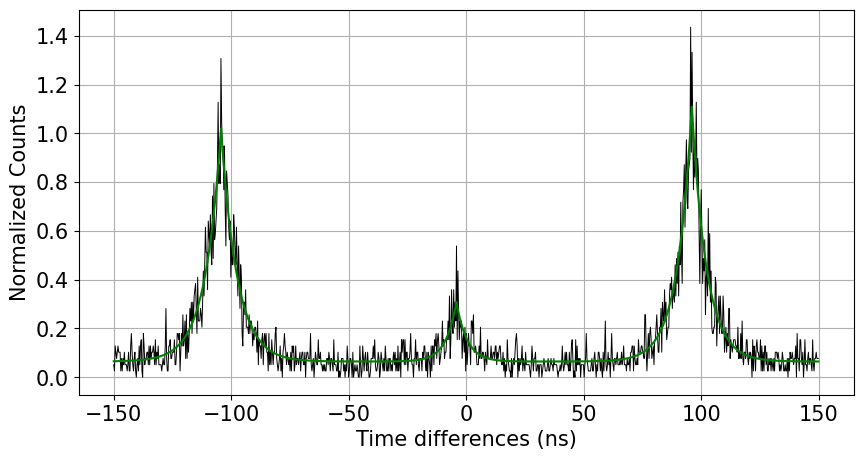

In [25]:
# Plot the normalized data and the fitted curve
plot_fit_noblinking(xcorr/1000, counts_normalized, params, width=10, height=5, font_size=15)

In [21]:
print(f"Normalized g^(2)(tau = 0): {(params[0] + params[4]):.3f} ± {np.sqrt((perr[0]**2 + perr[4]**2)):.3f}")

Normalized g^(2)(tau = 0): 0.308 ± 0.024
